In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.externals import joblib

%matplotlib inline

In [2]:
class BADS(object):
    def __init__(self):
        # Data
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.X_train_cv = None
        self.X_valid_cv = None
        self.y_train_cv = None
        self.y_valid_cv = None
        self.column_names = None
        # Classifiers
        self.clf = None
        self.clf_cv = None
        
        # Cost matrix
        self.cm = np.array([[3., 0.], [-10., 0.]])
        
        # variables to be set
        self.rs = 90049
        self.save_model = False

        ######### Feature Selection #########
        self.manual_features_to_remove = ["item_count", "x_order_date_num"]
        self.feature_correlation_removal = False
        self.feature_correlation_threshold = 0.7
        self.automatic_feature_selection = False
        self.automatic_feature_threshold = 0.005

        ######### Oversampling #########
        # non-standard package: http://contrib.scikit-learn.org/imbalanced-learn/index.html
        self.oversample_method = "none"

        ######### Cross-Valdiation #########
        self.do_cv = False # this takes a long time
        self.cv_num_folds = 4
        self.cv_validation_frac = 0.15
        self.cv_rs_iters = 20
        self.cost_func = self.bads_costs # bads_costs, roc_auc_score
        self.score_func = self.bads_scorer # bads_scorer, roc_auc_score
        self.set_model("rf") # "rf" or "gbc" or "linear"

    def set_model(self, model_to_use):
        self.model_to_use = model_to_use
        ######### Model Selection #########
        if model_to_use == "rf":
            # Random Forest Classifier
            from sklearn.ensemble import RandomForestClassifier
            self.clf = RandomForestClassifier(random_state=self.rs)
            self.automatic_feature_selection_params = {'n_estimators': 250, 'verbose': 0, 'n_jobs': 3}
            self.clf_default_params = {'min_samples_split': 2, 'n_estimators': 250, 
                                       'min_samples_leaf': 9, 'verbose': 0, 'n_jobs': 3}
            self.cv_param_grid = {'n_estimators':[100, 250, 500], 
                                  'min_samples_split':[2, 4, 8], 
                                  'min_samples_leaf': [1, 3, 9, 15], 
                                  'n_jobs': [3]}
        elif model_to_use == "gbc":
            # Gradient Boosting Classifier
            from sklearn.ensemble import GradientBoostingClassifier
            self.clf = GradientBoostingClassifier(random_state=self.rs)
            self.automatic_feature_selection_params = {'n_estimators': 50, 'verbose': 1}
            self.clf_default_params = {'learning_rate': 0.1, 'max_depth': 3, 
                                       'n_estimators': 100, 'verbose': 1}
            self.cv_param_grid = {'n_estimators':[50, 100, 250, 500], 
                                  'learning_rate':[0.05, 0.1, .25], 
                                  'max_depth': [3, 5, 9]}
        elif model_to_use == "linear":
            # Logistic Regression Classifier
            from sklearn import linear_model
            self.clf = linear_model.LogisticRegression()
            self.clf_default_params = {'penalty': 'l1'}
            self.cv_param_grid = {'penalty':['l1', 'l2'], 'C': 2 ** np.linspace(-3, 5, 17), 'n_jobs': [3]}
        else:
            print("Please Set The Model")

    def loadDataset(self, df, date_to_int = True):
        # remove NA
        df.fillna(-99, inplace = True)
        # Convert Dates
        df.order_date = pd.to_datetime(df.order_date, format='%Y-%m-%d')
        df.account_creation_date = pd.to_datetime(df.account_creation_date, format='%Y-%m-%d')
        df.deliverydate_estimated = pd.to_datetime(df.deliverydate_estimated, format='%Y-%m-%d')
        df.deliverydate_actual = pd.to_datetime(df.deliverydate_actual, format='%Y-%m-%d')
        # Create weekday dummy for order_date
        df['x_order_date_is_weekday'] = df.order_date.dt.dayofweek < 5
        if date_to_int:
            epoch_date = pd.Timestamp("2013-01-01")
            df.order_date = (df.order_date - epoch_date).astype('timedelta64[D]').astype(int)
            df.account_creation_date = (df.account_creation_date - epoch_date).astype('timedelta64[D]').astype(int)
            df.deliverydate_estimated = (df.deliverydate_estimated - epoch_date).astype('timedelta64[D]').astype(int)
            df.deliverydate_actual = (df.deliverydate_actual - epoch_date).astype('timedelta64[D]').astype(int)
        # Convert Categories (factors in R lingo)
        cols_to_categorize = ["model", "form_of_address", "email_domain", "postcode_invoice", "postcode_delivery", 
                              "payment", "advertising_code", "x_order_date_yearweek"]
        # Categorize _bin columns
        cols = df.columns
        cols_to_categorize.extend(cols[cols.str.contains("_bin")].values.tolist())
        for col_to_cat in cols_to_categorize:
            #print(col_to_cat)
            df[col_to_cat] = df[col_to_cat].astype('category')
        return(df)

    def simple_oversample_idx(self, y):
        y_idx_0 = np.where(y == 0)[0]
        y_idx_1 = np.random.choice(np.where(y == 1)[0], size=y_idx_0.shape[0], replace=True)
        ret_cust_idx = []
        ret_cust_idx.extend(y[y_idx_0])
        ret_cust_idx.extend(y[y_idx_1])
        return(ret_cust_idx)

    def bads_costs(self, y_t, yhat):
        N = yhat.shape[0]
        C = confusion_matrix(y_t, yhat)
        return(np.multiply(C, self.cm).sum() / N)

    def bads_scorer(self, y_t, yhat_prob):
        thresholds = np.linspace(0.01, 0.99)
        costs = [self.bads_costs(y_t, yhat_prob[:,1] > threshold) for threshold in thresholds]
        return(np.max(costs))

    def find_corr_features(self, df, threshold = 0.7):
        cols = df.columns.values.tolist()
        corr_mat = df.corr()
        corr_items = np.where(np.abs(np.triu(corr_mat, k=1)) > threshold)
        cols_removed = []
        for corr_item in list(set([cols[max(item)] for item in zip(*corr_items)])):
            cols_removed.append(corr_item)
            cols.remove(corr_item)
        print("Removing Columns:", ", ".join(cols_removed))
        return(cols)

    def create_datasets(self):
        train = pd.read_csv("output/train_cleaned.csv", sep=";", index_col="ID")
        train = self.loadDataset(train)
        # Create Feature List
        features_to_use = train.columns.values.tolist()
        features_to_use.remove("return_customer")
        for ftr in self.manual_features_to_remove:
            features_to_use.remove(ftr)
        # remove dates if not converted to ints
        for date_feature, v in train.dtypes.items():
            if v == "datetime64[ns]": 
                features_to_use.remove(date_feature)
        train = train[features_to_use + ["return_customer"]]
        # Visualize Correlation before splitting out dummy variables
        if self.feature_correlation_removal: 
            sns.heatmap(train.drop("return_customer", 1).corr())
            plt.show()
        # Split out dummy variables    
        train = pd.get_dummies(train)
        # feature Correlation Removal
        if self.feature_correlation_removal:
            print("Removing correlated features...")
            noncorr_cols = find_corr_features(train.drop("return_customer", 1), 
                                              self.feature_correlation_threshold)
            train = train[noncorr_cols + ["return_customer"]]
        # set train datasets
        self.X_train, self.y_train = train.drop("return_customer", 1).values, train["return_customer"].values
        self.column_names = train.columns

        test = pd.read_csv("output/test_cleaned.csv", sep=";", index_col="ID")
        test = self.loadDataset(test)
        test = pd.get_dummies(test)
        # The following line gives the test set the same columns as the training set. 
        # This simultaneously adds columns to the test set and sets the values in those columns to 0 and 
        # drops any columns in the test set that did not exist in the training set.
        test = test.reindex(columns = self.column_names, fill_value=0)
        test.drop("return_customer", 1, inplace=True)
        # set test dataset
        self.X_test = test.values
        self.X_train_cv, self.X_valid_cv, self.y_train_cv, self.y_valid_cv = train_test_split(self.X_train, 
                                                                                              self.y_train, 
                                                                                              test_size = self.cv_validation_frac,
                                                                                              stratify = self.y_train,
                                                                                              random_state = self.rs)


    def oversample(self):
        if self.oversample_method == "simple":
            # oversampling with replacement of the minority group to equalize the size of the minority and 
            # majority group
            print("Simple oversampling...")
            # Create the Hyper-Parameter Cross-Validation train and test sets
            ret_cust_idx_cv = self.simple_oversample_idx(self.y_train_cv)
            self.X_train_cv, self.y_train_cv = self.X_train_cv[ret_cust_idx_cv,:], self.y_train_cv[ret_cust_idx_cv]
            # Create the full train and test sets
            ret_cust_idx = simple_oversample_idx(self.y_train)
            self.X_train, self.y_train = self.X_train[ret_cust_idx,:], self.y_train[ret_cust_idx]
        elif self.oversample_method == "SMOTE":
            # https://www.jair.org/media/953/live-953-2037-jair.pdf
            from imblearn.over_sampling import SMOTE

            print("SMOTE oversampling...")
            sm = SMOTE(kind='regular', random_state = self.rs)
            # Create the Hyper-Parameter Cross-Validation train and test sets
            self.X_train_cv, self.y_train_cv = sm.fit_sample(self.X_train_cv, self.y_train_cv)
            # Create the full train and test sets
            self.X_train, self.y_train = sm.fit_sample(self.X_train, self.y_train)
        elif self.oversample_method == "SMOTETomek":
            from imblearn.combine import SMOTETomek

            print("SMOTE + Tomek Links oversampling...")
            sm = SMOTETomek(random_state = rs)
            # Create the Hyper-Parameter Cross-Validation train and test sets
            self.X_train_cv, self.y_train_cv = sm.fit_sample(self.X_train_cv, self.y_train_cv)
            # Create the full train and test sets
            self.X_train, self.y_train = sm.fit_sample(self.X_train, self.y_train)
        else:
            print("No oversampling...")

    def automagic_feature_selection(self):
        if self.automatic_feature_selection:
            print("Starting automatic feature selection...")
            # this takes about 10 minutes to run
            self.clf.set_params(**self.automatic_feature_selection_params)
            self.clf.fit(self.X_train, self.y_train)
            important_features = np.where(self.clf.feature_importances_ > self.automatic_feature_threshold)[0].tolist()
            important_features_labels = self.column_names[important_features]
            print("High Importance Features:", ", ".join(important_features_labels.tolist()))
            np.savetxt("output/optimal_features.csv", important_features_labels.values, fmt="%s", delimiter=";")

            self.X_train, self.X_test = self.X_train[:,important_features], self.X_test[:,important_features]
            self.X_train_cv, self.X_valid_cv = self.X_train_cv[:,important_features], self.X_valid_cv[:,important_features]

        else:
            print("No automatic feature selection...")

    def run_model(self):
        if self.do_cv:
            # this can take a LONG time
            print("Searching for best parameters with CV search...")
            self.clf_cv = RandomizedSearchCV(self.clf, self.cv_param_grid, 
                                             scoring = make_scorer(self.score_func, needs_proba=True), 
                                             cv = self.cv_num_folds, 
                                             n_iter = self.cv_rs_iters, 
                                             random_state = self.rs, verbose = 1)
            self.clf_cv.fit(self.X_train_cv, self.y_train_cv)
            #clf_rf_cv.cv_results_
            joblib.dump(self.clf_cv.cv_results_, 'output/clf_rf_cv.results.pkl')
            print("Cross Valdiation Report:")
            print(self.clf_cv.best_params_)
            print("Best Score:", self.clf_cv.best_score_)
            # Plot Expected ROI per Customer
            plt.errorbar(range(self.cv_rs_iters), 
                         self.clf_cv.cv_results_["mean_test_score"], 
                         yerr = self.clf_cv.cv_results_["std_test_score"], 
                         fmt="o")
            plt.margins(0.03)
            plt.show()

            # Train and Validate a random forest classifier with the best parameters
            yhat_valid_prob = self.clf_cv.predict_proba(self.X_valid_cv)

            params_star = self.clf_cv.best_params_
            self.clf.set_params(**params_star)
        else:
            self.clf.set_params(**self.clf_default_params)
            self.clf.fit(self.X_train_cv, self.y_train_cv)
            yhat_valid_prob = self.clf.predict_proba(self.X_valid_cv)

        print("Validation Summary:")
        print("Calculate Optimal Threshold")
        thresholds = np.linspace(0.01, 0.99, 197)
        costs = [self.bads_costs(self.y_valid_cv, yhat_valid_prob[:,1] > threshold) for threshold in thresholds]
        threshold_star = thresholds[np.argmax(costs)]
        # Plot
        plt.plot(thresholds, costs)
        plt.show()
        print("Threshold:", threshold_star)
        yhat_valid = yhat_valid_prob[:,1] > threshold_star
        print("Average ROI:", self.cost_func(self.y_valid_cv, yhat_valid))
        print("ROC Score:", roc_auc_score(self.y_valid_cv, yhat_valid_prob[:,1]))
        print("Validation Return Customers: {} of {} ({}%)".format(np.sum(yhat_valid), 
                                                                   len(yhat_valid), 
                                                                   np.sum(yhat_valid)/len(yhat_valid)))
        print(confusion_matrix(self.y_valid_cv, yhat_valid))
        # Train model with all data and use on the Test set
        self.clf.fit(self.X_train, self.y_train)
        yhat_test_proba = self.clf.predict_proba(self.X_test)
        yhat_test = yhat_test_proba[:,1] > threshold_star
        np.savetxt("output/test_return_customer.csv", yhat_test.astype(int), fmt='%i', delimiter=";")
        print("Testing Return Customers: {} of {} ({}%)".format(np.sum(yhat_test), 
                                                                len(yhat_test), 
                                                                np.sum(yhat_test)/len(yhat_test)))

        if self.save_model:
            joblib.dump(self.clf, 'output/model_final.pkl')
            #clf_rf = joblib.load('output/model_final.pkl')


In [ ]:
#####################################
#
#  Variable Selection
#
#####################################
######### Set Seed #########
rs = 90049
save_model = False

######### Feature Selection #########
manual_features_to_remove = ["item_count", "x_order_date_num"]
feature_correlation_removal = False
feature_correlation_threshold = 0.7
automatic_feature_selection = False
automatic_feature_threshold = 0.005

######### Oversampling #########
# non-standard package: http://contrib.scikit-learn.org/imbalanced-learn/index.html
oversample_method = "none"

######### Cross-Valdiation #########
do_cv = False # this takes a long time
cv_num_folds = 4
cv_validation_frac = 0.15
cv_rs_iters = 10
cost_func = bads_costs # bads_costs, roc_auc_score
score_func = bads_scorer # bads_scorer, roc_auc_score
#cost_func = roc_auc_score # bads_costs, roc_auc_score
#score_func = roc_auc_score # bads_scorer, roc_auc_score

######### Model Selection #########
model_to_use = "rf" # "rf" or "gbc" or "linear"

if model_to_use == "rf":
    # Random Forest Classifier
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(random_state=rs)
    automatic_feature_selection_params = {'n_estimators': 250, 'verbose': 0, 'n_jobs': 3}
    clf_default_params = {'min_samples_split': 2, 'n_estimators': 250, 'min_samples_leaf': 9, 'verbose': 0, 'n_jobs': 3}
    cv_param_grid = {'n_estimators':[100, 250, 500], 'min_samples_split':[2, 4, 8], 'min_samples_leaf': [1, 3, 9], 'n_jobs': [3]}
elif model_to_use == "gbc":
    # Gradient Boosting Classifier
    from sklearn.ensemble import GradientBoostingClassifier
    clf = GradientBoostingClassifier(random_state=rs)
    automatic_feature_selection_params = {'n_estimators': 50, 'verbose': 1}
    clf_default_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'verbose': 1}
    cv_param_grid = {'n_estimators':[50, 100, 250, 500], 'learning_rate':[0.05, 0.1, .25], 'max_depth': [3, 5, 9]}
elif model_to_use == "linear":
    # Logistic Regression Classifier
    from sklearn import linear_model
    clf = linear_model.LogisticRegression()
    clf_default_params = {'penalty': 'l1'}
    cv_param_grid = {'penalty':['l1', 'l2'], 'C': 2 ** np.linspace(-3, 5, 17), 'n_jobs': [3]}
else:
    print("Invalid Model Selected")
    


No oversampling...
No automatic feature selection...
(51884, 402) (12971, 402) (44101, 402) (7783, 402)
Validation Summary:
Calculate Optimal Threshold


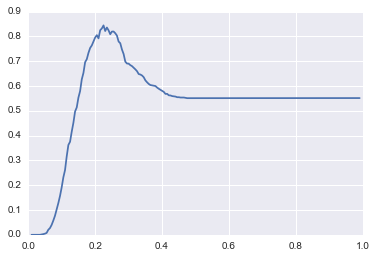

Threshold: 0.225
Average ROI: 0.844404471284
ROC Score: 0.662009236429
Validation Return Customers: 2169 of 7783 (0.2786843119619684%)
[[4824 1493]
 [ 790  676]]
Testing Return Customers: 3582 of 12971 (0.27615449849664636%)


In [4]:
a = BADS()
# Load and split training  and testing data and create cross validation sets from training data
a.create_datasets()
# Oversample if desired
a.oversample()
# Run algorithm-based feature selection
a.automagic_feature_selection()
# Print size of training sets
print(a.X_train.shape, a.X_test.shape, a.X_train_cv.shape, a.X_valid_cv.shape)
# Change a few variables as a test
a.set_model("rf")
a.do_cv = False
# Run the models
a.run_model()

In [ ]:
# Run the model



In [ ]:
# PCA Analysis of Results

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

num_PC = 5

train_scaled = scale(X_train)
pca = PCA(n_components=num_PC)
pca.fit(train_scaled)
train_rotated = pca.transform(train_scaled)
df_train = pd.DataFrame(train_rotated)
df_train["colors"] = y_train
sns.pairplot(df_train, hue = "colors", diag_kind="kde", vars=range(num_PC))
plt.show()
test_scaled = scale(X_test)
test_rotated = pca.transform(test_scaled)
df_test = pd.DataFrame(test_rotated)
df_test["colors"] = yhat_test
sns.pairplot(df_test, hue = "colors", diag_kind="kde", vars=range(num_PC))
plt.show()

## Tests Below This Point

In [ ]:
# Single Random Forest

cost_func = roc_auc_score # bads_costs roc_auc_score

clf_rf = RandomForestClassifier(n_estimators=4000)

clf_rf.fit(X_train_cv, y_train_cv)
yhat_valid = clf_rf.predict(X_valid_cv)
print("Validation Summary:")
print(cost_func(y_valid_cv, yhat_valid))
print("Validation: {} of {} ({}%)".format(np.sum(yhat_valid), len(yhat_valid), np.sum(yhat_valid)/len(yhat_valid)))
print(confusion_matrix(y_valid_cv, yhat_valid))

clf_rf.fit(X_train, y_train)
print("Test Results")
yhat = clf_rf.predict(X_test)
print("{} of {}".format(np.sum(yhat), len(yhat)))

In [ ]:
# Gradient Boost Classifier (testing)

cost_func = roc_auc_score # bads_costs roc_auc_score

clf_gbc = GradientBoostingClassifier(learning_rate=0.05, n_estimators=500, random_state=1234, verbose=1)
clf_gbc.fit(X_train_cv, y_train_cv)
yhat_valid = clf_gbc.predict(X_valid_cv)
print("Validation Summary:")
print(cost_func(y_valid_cv, yhat_valid))
print("Validation: {} of {}".format(np.sum(yhat_valid), len(yhat_valid)))
print(confusion_matrix(y_valid_cv, yhat_valid))
print(X_train.columns[np.where(clf_gbc.feature_importances_ > 0.005)])

In [ ]:
# Sample Confusion Matrix

a = np.array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0])
b = np.array([True, False, False, False, False, False, True, True, True, True])
confusion_matrix(a,b), bads_costs(a,b)

In [ ]:
plt.errorbar(range(10), clf_cv.cv_results_["mean_test_score"], yerr = clf_cv.cv_results_["std_test_score"], fmt="o")
plt.margins(0.03)

## Results

### Gradient Boosting: SMOTE+Tomek, 500 iterations, .1 eta, 5 max_depth, no decorrellation, no feature selection, no hyper-parameter search

Time: ~45m

Validation Summary:
Calculate Optimal Threshold

Threshold: 0.29
0.772966722344
Validation Return Customers: 1193 of 7783
[[5532  785]
 [1058  408]]
Testing Return Customers: 1478 of 12971

### Gradient Boosting: SMOTE+Tomek, 50 iterations, .25 eta, 5 max_depth, no decorrellation, no feature selection, no hyper-parameter search

Time: ~5m; iter: 50; training loss: 0.5494
Validation Summary:
Calculate Optimal Threshold

Threshold: 0.23
0.775664910703
Validation Return Customers: 2239 of 7783
[[4729 1588]
 [ 815  651]]
Testing Return Customers: 3694 of 12971

### Gradient Boosting: SMOTE+Tomek, 50 iterations, .25 eta, 12 max_depth, no decorrellation, no feature selection, no hyper-parameter search

Time: 30.77m; iter: 50; training loss: 0.3084

Validation Summary:
Calculate Optimal Threshold

Threshold: 0.25
0.687909546447
Validation Return Customers: 1613 of 7783
[[5158 1159]
 [1012  454]]
Testing Return Customers: did not complete

### Gradient Boosting: No Oversampling, 50 iterations, .25 eta, 12 max_depth, no decorrellation, no feature selection, no hyper-parameter search

Time: 23.24m; iter: 50; training loss: 0.4498
Validation Summary:
Calculate Optimal Threshold

Threshold: 0.17
0.67814467429
Validation Return Customers: 2687 of 7783
[[4326 1991]
 [ 770  696]]
Testing Return Customers: 3321 of 12971

### Gradient Boosting: No Oversampling, 50 iterations, .15 eta, 3 max_depth, no decorrellation, no feature selection, no hyper-parameter search

Time: 1.20m; iter: 50; training loss: 0.9077
Validation Summary:
Calculate Optimal Threshold

Threshold: 0.21
0.812925607092
Validation Return Customers: 2294 of 7783
[[4709 1608]
 [ 780  686]]
Testing Return Customers: 3924 of 12971

### Gradient Boosting: No Oversampling, 50 iterations, .15 eta, 3 max_depth, decorrelation, feature selection, no hyper-parameter search

Time: 4.51m; iter: 50; training loss: 0.9096

Validation Summary:
Calculate Optimal Threshold

Threshold: 0.21
0.824617756649
Validation Return Customers: 2385 of 7783
[[4646 1671]
 [ 752  714]]
Testing Return Customers: 4003 of 12971

### Gradient Boosting: No Oversampling, 100 iterations, .05 eta, 3 max_depth, decorrelation, feature selection, no hyper-parameter search

Time: 7.99m; iter: 100; training loss: 0.9159
Validation Summary:
Calculate Optimal Threshold

Threshold: 0.23
0.809970448413
Validation Return Customers: 1669 of 7783
[[5188 1129]
 [ 926  540]]
Testing Return Customers: 2815 of 12971

---

### RandomForest: No Oversampling, 500 trees, min sample split 4, min leaf size 9, decorr, gb feature selection, no hyper-parameter search

Time: ~2m

Validation Summary:
Calculate Optimal Threshold

Threshold: 0.23
0.800848002056
Validation Return Customers: 2178 of 7783
[[4791 1526]
 [ 814  652]]
Testing Return Customers: 3700 of 12971


Validation Summary:
Calculate Optimal Threshold

### RandomForest: No Oversampling, All Bin to Cat, 500 trees, min sample split 4, min leaf size 9, no decorr, no feature selection, no hyper-parameter search

Validation Summary:
Calculate Optimal Threshold

Threshold: 0.24
Average ROI: 0.837851728125
ROC Score: 0.662306189517
Validation Return Customers: 1705 of 7783 (0.21906719773866118%)
[[5177 1140]
 [ 901  565]]
Testing Return Customers: 2801 of 12971 (0.21594325803715983%)


### RandomForest: No Oversampling, All Bin to Cat, 500 trees, min sample split 4, min leaf size 9, decorr, rf feature selection, no hyper-parameter search

Validation Summary:
Calculate Optimal Threshold

Threshold: 0.23
Average ROI: 0.788513426699
ROC Score: 0.647177725452
Validation Return Customers: 2184 of 7783 (0.28061158936142877%)
[[4779 1538]
 [ 820  646]]
Testing Return Customers: 4028 of 12971 (0.31053889445686533%)

### RandomForest: SMOTE Oversampling, All Bin to Cat, 500 trees, min sample split 4, min leaf size 9, decorr, rf feature selection, no hyper-parameter search

Validation Summary:
Calculate Optimal Threshold

Threshold: 0.27
Average ROI: 0.796479506617
ROC Score: 0.64603845143
Validation Return Customers: 2016 of 7783 (0.2590260824874727%)
[[4913 1404]
 [ 854  612]]
Testing Return Customers: 8841 of 12971 (0.6815974096060442%)

### Logistic Regression: no Oversampling, L1 Penalty, C = 0.5, no decorr, no feature selection, rand hyper-parameter search

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Done  40 out of  40 | elapsed: 27.8min finished

{'n_jobs': 3, 'C': 0.5, 'penalty': 'l1'}
Best Score: 0.794607832022

Validation Summary:
Calculate Optimal Threshold

Threshold: 0.23
Average ROI: 0.783374020301
ROC Score: 0.649006146605
Validation Return Customers: 1998 of 7783 (0.25671334960812026%)
[[4919 1398]
 [ 866  600]]
Testing Return Customers: 3266 of 12971 (0.25179246010330736%)

### Random Forest: no Oversampling, min_sample_leaf = 9, n_estimators = 250, min_samples_split = 2, no decorr, no feature selection, rand hyper-parameter search

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Done  40 out of  40 | elapsed: 71.8min finished
Cross Valdiation Report:
{'n_jobs': 3, 'min_samples_leaf': 9, 'n_estimators': 250, 'min_samples_split': 2}
Best Score: 0.811478197773

Validation Summary:
Calculate Optimal Threshold

Threshold: 0.235
Average ROI: 0.833097777207
ROC Score: 0.662557465822
Validation Return Customers: 1856 of 7783 (0.23846845689322882%)
[[5058 1259]
 [ 869  597]]
Testing Return Customers: 3057 of 12971 (0.23567959293809268%)


In [ ]:
RandomizedSearchCV?

In [ ]:
m = np.array([[3., 0.], [-10., 0.]])
cm0 = confusion_matrix(train.return_customer, np.zeros(train.return_customer.count()))
cm1 = confusion_matrix(train.return_customer, np.ones(train.return_customer.count()))
costs = np.multiply(cm0, m)
print(cm0);print(m);print(costs);print(costs.sum()/train.return_customer.count());print(np.multiply(cm1, m).sum()/train.return_customer.count())

0.50333758430304909

In [ ]:
a.set_model("linear")
a.do_cv = True
a.run_model()
